Cell 1 – Load and Preprocess Data

In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('/content/sample_data/dengue data 17-07-2025.csv')
df['week_start_date'] = pd.to_datetime(df['week_start_date'], dayfirst=True)
df.set_index('week_start_date', inplace=True)

# Focus on San Juan city
df = df[df['city'] == 'sj']
df.drop(['city'], axis=1, inplace=True)

# Fill missing values
df.fillna(method='ffill', inplace=True)


/tmp/ipython-input-64-2881777174.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Cell 2 – Separate and Scale Features & Target

In [65]:
# Scale features (excluding target)
feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(df.drop(['total_cases'], axis=1))

# Scale target separately
target = df['total_cases'].values.reshape(-1, 1)
target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(target)


Cell 3 – Sequence Preparation

In [66]:
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(scaled_features, scaled_target, sequence_length)


Cell 4 – Train-Test Split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


Cell 5 – Model Building

In [68]:
model = Sequential([
    GRU(units=256, dropout=0.2, recurrent_dropout=0.2,
        activation='tanh', recurrent_activation='sigmoid',
        input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_9 (GRU)                     │ (None, 256)            │       215,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,297 (841.00 KB)

 Trainable params: 215,297 (841.00 KB)

 Non-trainable params: 0 (0.00 B)

Cell 6 – Training the Model

In [69]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.0614 - mae: 0.2018 - val_loss: 0.0094 - val_mae: 0.0943
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0274 - mae: 0.1197 - val_loss: 9.6629e-04 - val_mae: 0.0255
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0209 - mae: 0.0868 - val_loss: 0.0147 - val_mae: 0.1141
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0152 - mae: 0.0782 - val_loss: 0.0065 - val_mae: 0.0736
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0168 - mae: 0.0779 - val_loss: 0.0035 - val_mae: 0.0516
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0123 - mae: 0.0657 - val_loss: 0.0080 - val_mae: 0.0832
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0166 - mae: 0.0757 - val_loss: 0.0033 - val_mae: 0.0460
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0149 - mae: 0.0714 - val_loss: 0.0011 - val_mae: 0.0253
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/st

Cell 7 – Plot Loss Curves



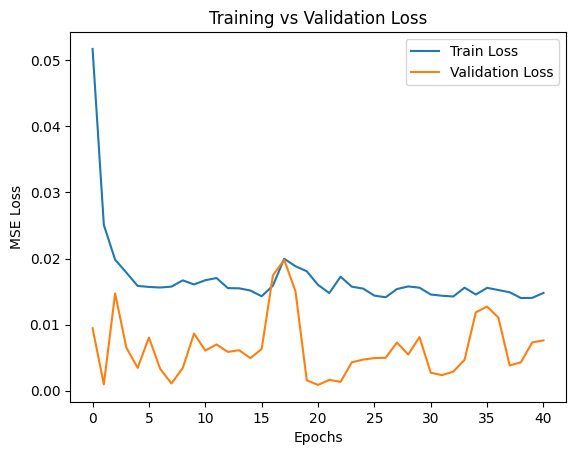

In [70]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.show()


Cell 8 – Model Evaluation


In [71]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0043 - mae: 0.0449
Test Loss: 0.0046, Test MAE: 0.0446


Cell 9 – Make Predictions and Inverse Transform

In [72]:
# Predict
predicted_scaled = model.predict(X_test)

# Inverse transform predictions and actual values
predicted_cases = target_scaler.inverse_transform(predicted_scaled)
actual_cases = target_scaler.inverse_transform(y_test)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


Cell 10 – Plot Actual vs Predicted

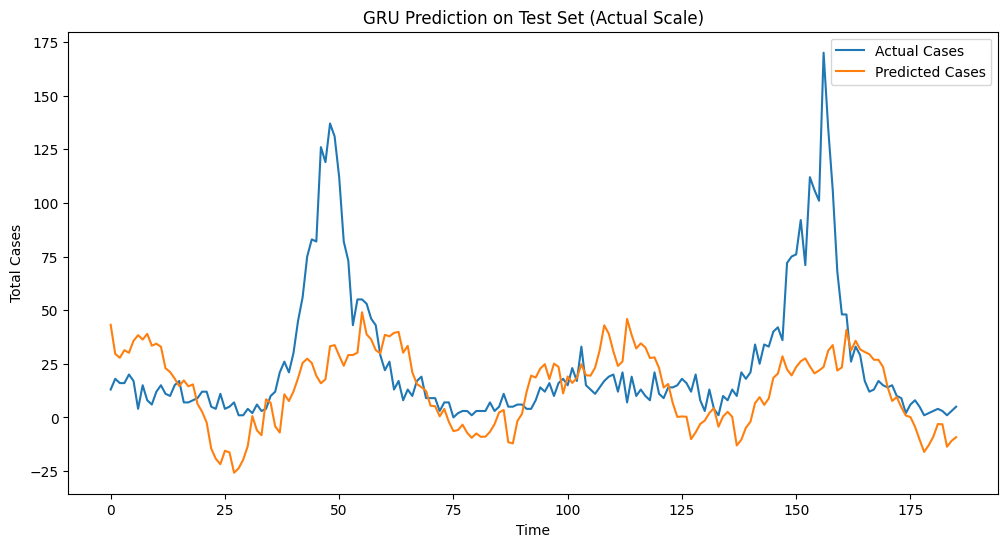

In [73]:
plt.figure(figsize=(12,6))
plt.plot(actual_cases, label='Actual Cases')
plt.plot(predicted_cases, label='Predicted Cases')
plt.title('GRU Prediction on Test Set (Actual Scale)')
plt.xlabel('Time')
plt.ylabel('Total Cases')
plt.legend()
plt.show()


# **Second Code**

Cell 1 – Imports & Setup

/tmp/ipython-input-75-4170573786.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Data shape after city filtering: (936, 23)
City selected: sj


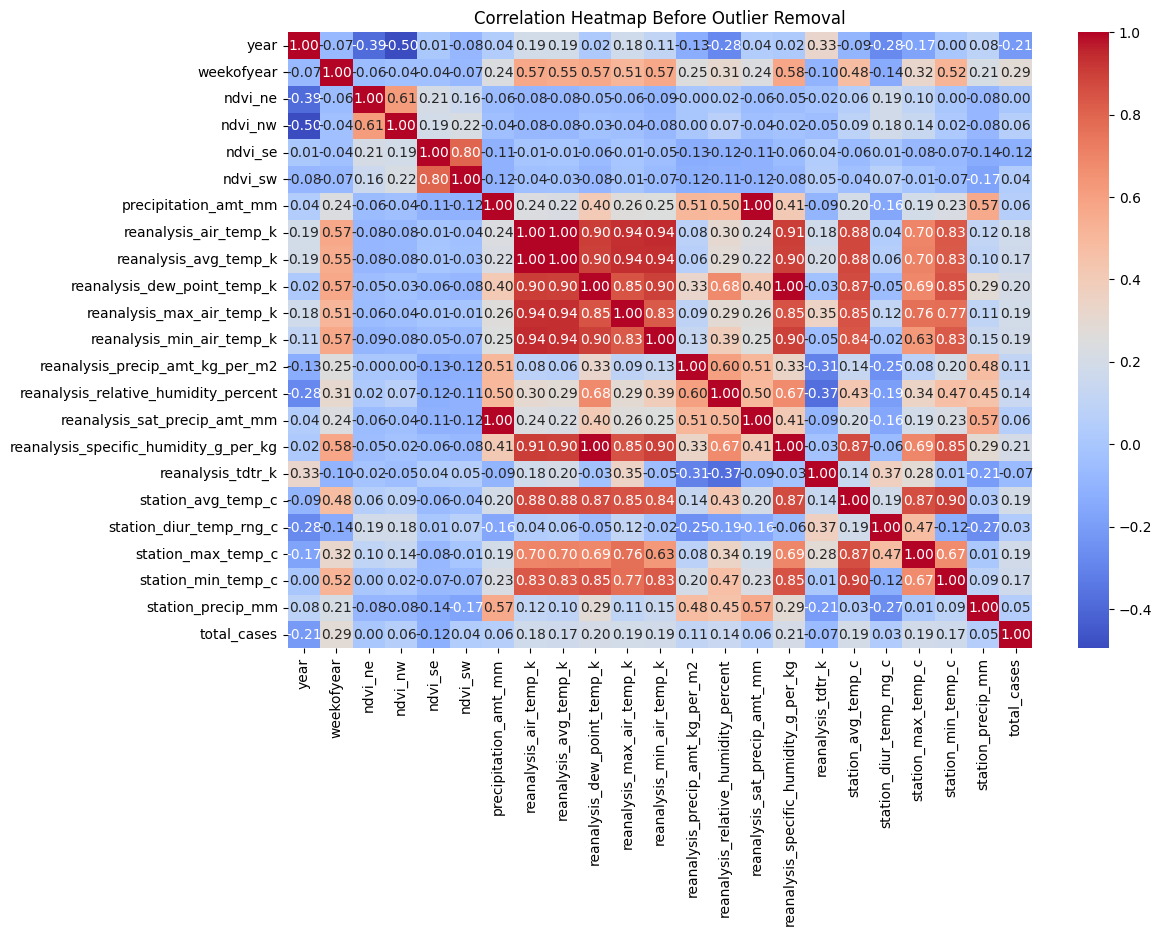

In [75]:
# Cell 1: Imports and city filtering
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

# Load data
df = pd.read_csv('/content/sample_data/dengue data 17-07-2025.csv')

# Choose one city only (e.g., 'sj' or 'iq')
selected_city = 'sj'  # 👈 Change to 'iq' for Iquitos
df = df[df['city'] == selected_city].copy()

# Drop unused columns
df.drop(columns=['city', 'week_start_date'], inplace=True)

# Forward fill NaNs
df.fillna(method='ffill', inplace=True)

# --- Visualization ---
print("Data shape after city filtering:", df.shape)
print("City selected:", selected_city)

## Missing data heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
# plt.title("Missing Data Heatmap Before Outlier Removal")
# plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap Before Outlier Removal")
plt.show()


Cell 2: Visualize Outliers Before Removal with Heatmap

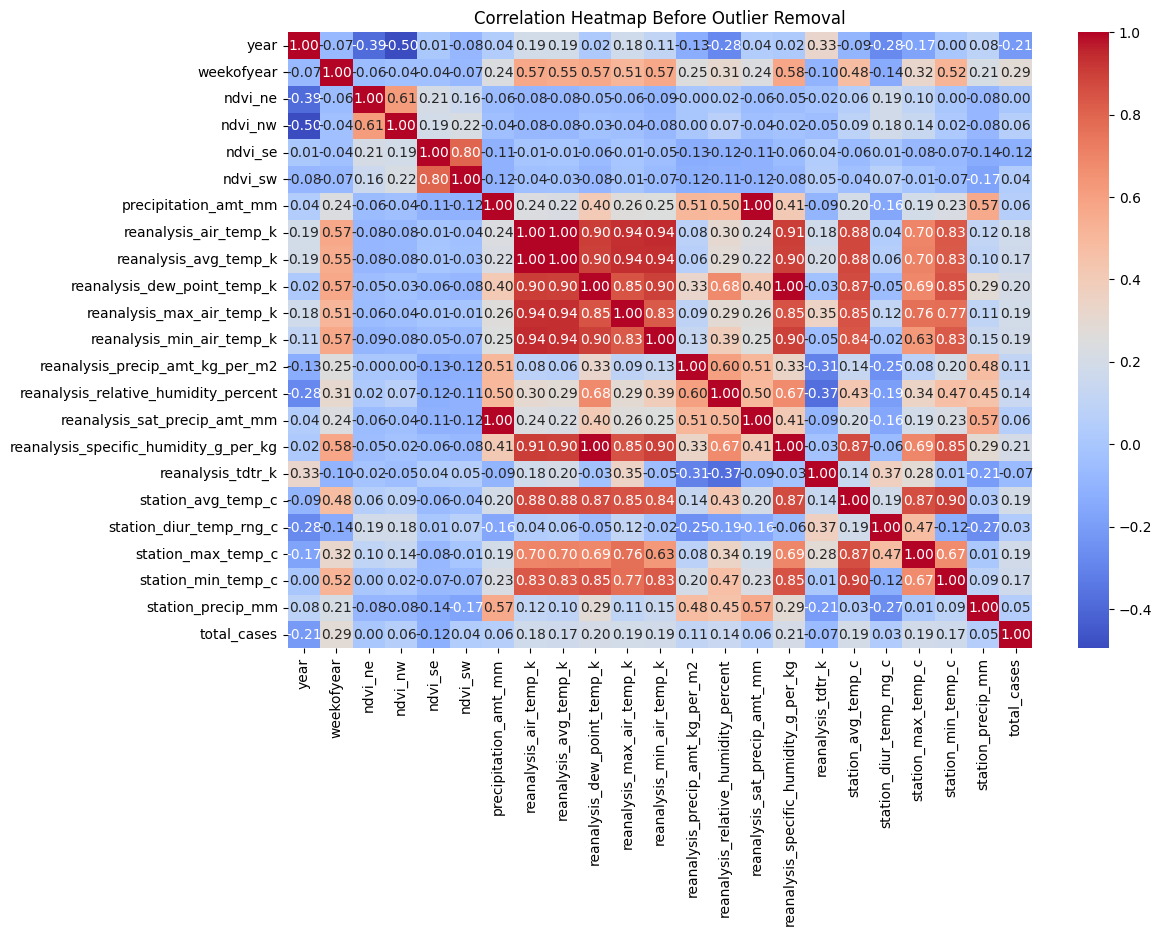

In [76]:
# plt.figure(figsize=(12, 8))
# sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
# plt.title("Missing Data Heatmap Before Outlier Removal")
# plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap Before Outlier Removal")
plt.show()


Cell 3: Outlier Removal Using IQR & Visualize After Removal

Rows before outlier removal: 936
Rows after outlier removal: 644


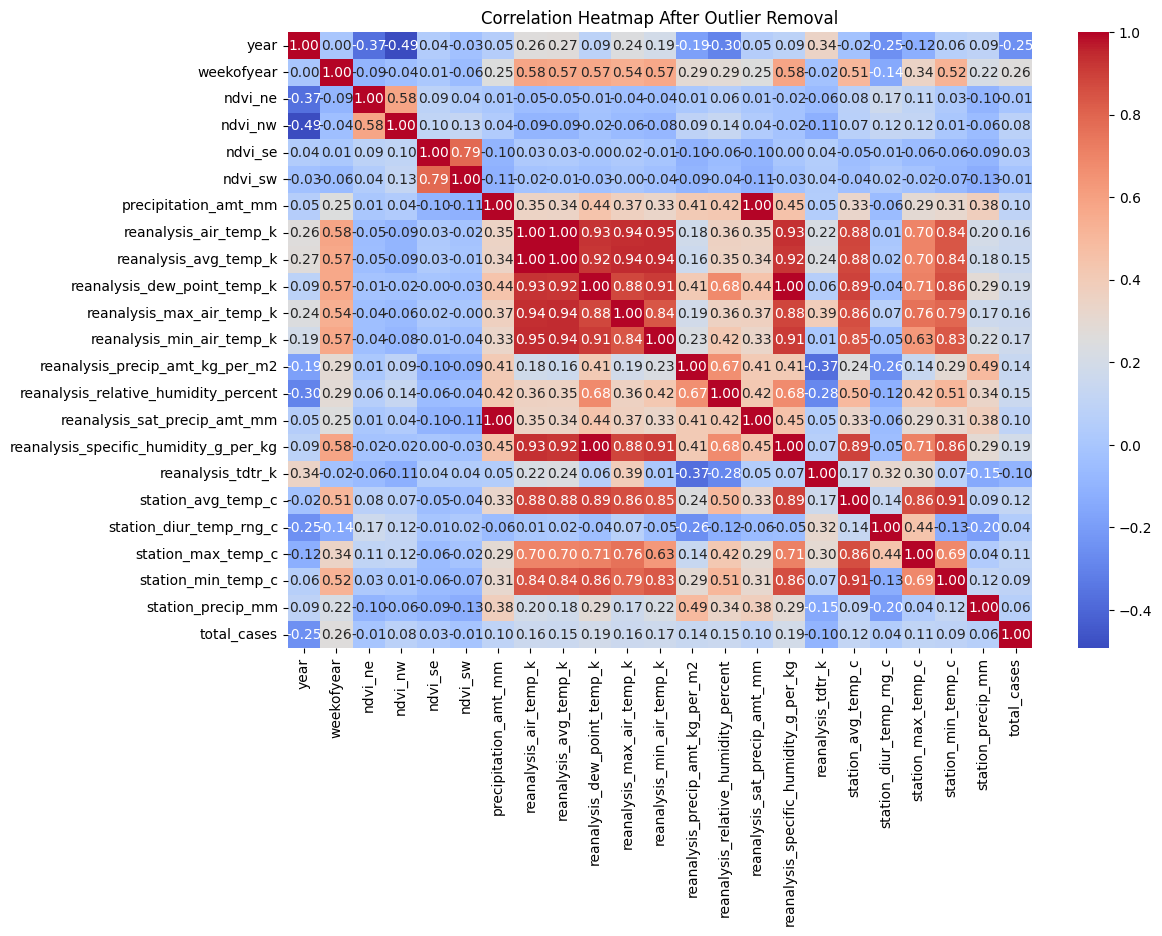

In [77]:
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    condition = ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[condition]

df_no_outliers = remove_outliers(df)

print(f"Rows before outlier removal: {len(df)}")
print(f"Rows after outlier removal: {len(df_no_outliers)}")

# plt.figure(figsize=(12, 8))
# sns.heatmap(df_no_outliers.isnull(), cbar=False, yticklabels=False)
# plt.title("Missing Data Heatmap After Outlier Removal")
# plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df_no_outliers.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap After Outlier Removal")
plt.show()


Cell 4: Lag Features Creation & Target/Feature Separation




In [78]:
df = df_no_outliers.copy()

for lag in [1, 2, 3]:
    df[f'total_cases_lag{lag}'] = df['total_cases'].shift(lag)

df.dropna(inplace=True)

target_col = 'total_cases'
features = df.drop(columns=[target_col])


Cell 5: Remove Low Variance & High Correlation Features

In [79]:
def drop_low_variance(df, thresh=0.01):
    sel = VarianceThreshold(thresh)
    return df[df.columns[sel.fit(df).get_support()]]

def drop_high_corr(df, thresh=0.9):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > thresh)]
    return df.drop(columns=to_drop)

features = drop_low_variance(features)
features = drop_high_corr(features)

features


,year,weekofyear,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_precip_mm,total_cases_lag1,total_cases_lag2,total_cases_lag3
3,1990,21,15.36,298.987143,13.90,80.337143,2.428571,27.471429,6.771429,33.3,4.0,4.0,5.0,4.0
5,1990,23,9.58,299.630000,26.49,79.891429,2.100000,28.114286,6.942857,34.4,39.1,3.0,4.0,5.0
6,1990,24,3.48,299.207143,38.60,82.000000,2.042857,27.414286,6.771429,32.2,29.7,2.0,3.0,4.0
8,1990,26,19.32,299.578571,37.51,82.768571,1.885714,28.328571,7.385714,33.9,21.1,4.0,2.0,3.0
9,1990,27,14.41,300.154286,28.40,81.281429,2.014286,28.328571,6.514286,33.9,1.1,10.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,2008,9,0.00,297.765714,6.46,72.660000,2.285714,24.742857,5.500000,27.8,12.9,8.0,6.0,15.0
928,2008,10,0.00,297.878571,6.50,74.681429,2.614286,25.114286,6.114286,29.4,13.0,5.0,8.0,6.0
931,2008,13,27.19,296.958571,7.55,74.247143,2.885714,25.042857,5.785714,30.0,1.8,1.0,5.0,8.0
932,2008,14,3.82,298.081429,3.67,74.600000,2.714286,26.242857,6.814286,30.6,0.5,4.0,1.0,5.0


Cell 6: Scale Features and Target

In [80]:
feat_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_feat = feat_scaler.fit_transform(features)
y = df[target_col].values.reshape(-1, 1)
y_scaled = target_scaler.fit_transform(y)

print("Feature shape:", X_feat.shape)
print("Target shape:", y_scaled.shape)


Feature shape: (641, 14)
Target shape: (641, 1)


Cell 7.1: Reshape into Sequences for GRU

In [81]:
def create_sequences(X_data, y_data, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - seq_len):
        X_seq.append(X_data[i:i+seq_len])
        y_seq.append(y_data[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 10  # you can tune this
X, y = create_sequences(X_feat, y_scaled, sequence_length)

# Final train-test split
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


In [83]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.3 MB/s eta 0:00:00


 Cell 8: GRU Model & Optuna Objective

In [84]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

def create_gru_model(input_shape, trial):
    model = Sequential()
    n_layers = trial.suggest_int('n_layers', 1, 3)

    for i in range(n_layers):
        units = trial.suggest_int(f'units_l{i}', 64, 256, step=32)
        dropout = trial.suggest_float(f'dropout_l{i}', 0.1, 0.5)
        return_seq = i < n_layers - 1

        if i == 0:
            model.add(GRU(units, return_sequences=return_seq, input_shape=input_shape))
        else:
            model.add(GRU(units, return_sequences=return_seq))
        model.add(Dropout(dropout))

    model.add(Dense(1))
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'nadam', 'rmsprop'])
    model.compile(optimizer=optimizer, loss='mse')
    return model

def objective(trial):
    model = create_gru_model((X_train.shape[1], X_train.shape[2]), trial)

    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=trial.suggest_categorical('batch_size', [32, 64, 128]),
        callbacks=[early_stop],
        verbose=0
    )

    y_pred_val = model.predict(X_test)
    val_mse = mean_squared_error(y_test, y_pred_val)
    return val_mse


 Cell 9: Run Optuna Tuning

In [85]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_trial.params)


[I 2025-07-29 10:44:39,042] A new study created in memory with name: no-name-37b00d40-d5f4-497b-9747-b6fe61a88737
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


[I 2025-07-29 10:44:50,133] Trial 0 finished with value: 0.02262664109432752 and parameters: {'n_layers': 1, 'units_l0': 160, 'dropout_l0': 0.21935010213602146, 'optimizer': 'nadam', 'batch_size': 64}. Best is trial 0 with value: 0.02262664109432752.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


[I 2025-07-29 10:45:20,701] Trial 1 finished with value: 0.024082536122853142 and parameters: {'n_layers': 2, 'units_l0': 128, 'dropout_l0': 0.38820786718723643, 'units_l1': 128, 'dropout_l1': 0.22426915174035328, 'optimizer': 'nadam', 'batch_size': 64}. Best is trial 0 with value: 0.02262664109432752.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


[I 2025-07-29 10:45:34,401] Trial 2 finished with value: 0.022918378426345216 and parameters: {'n_layers': 1, 'units_l0': 128, 'dropout_l0': 0.20485536665511062, 'optimizer': 'nadam', 'batch_size': 32}. Best is trial 0 with value: 0.02262664109432752.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


[I 2025-07-29 10:45:58,475] Trial 3 finished with value: 0.023834879096769925 and parameters: {'n_layers': 2, 'units_l0': 64, 'dropout_l0': 0.4656692404217887, 'units_l1': 128, 'dropout_l1': 0.22716857641294452, 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 0 with value: 0.02262664109432752.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


[I 2025-07-29 10:46:52,666] Trial 4 finished with value: 0.02354883756801321 and parameters: {'n_layers': 3, 'units_l0': 256, 'dropout_l0': 0.176099030879926, 'units_l1': 224, 'dropout_l1': 0.14779503992690085, 'units_l2': 256, 'dropout_l2': 0.4431882139606059, 'optimizer': 'nadam', 'batch_size': 128}. Best is trial 0 with value: 0.02262664109432752.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-07-29 10:47:47,181] Trial 5 finished with value: 0.024390952003215085 and parameters: {'n_layers': 3, 'units_l0': 64, 'dropout_l0': 0.32817659552203826, 'units_l1': 160, 'dropout_l1': 0.23722546805303618, 'units_l2': 224, 'dropout_l2': 0.29312942915281065, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 0 with value: 0.02262664109432752.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


[I 2025-07-29 10:48:29,964] Trial 6 finished with value: 0.024111503512177446 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.346878401169611, 'units_l1': 192, 'dropout_l1': 0.4665718153773799, 'units_l2': 192, 'dropout_l2': 0.38098970798792176, 'optimizer': 'nadam', 'batch_size': 32}. Best is trial 0 with value: 0.02262664109432752.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step


[I 2025-07-29 10:49:17,357] Trial 7 finished with value: 0.022999873308931412 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.29130702399946473, 'units_l1': 128, 'dropout_l1': 0.4029217508247539, 'units_l2': 96, 'dropout_l2': 0.20050744750263416, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 0 with value: 0.02262664109432752.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


[I 2025-07-29 10:49:46,672] Trial 8 finished with value: 0.02487533910388897 and parameters: {'n_layers': 2, 'units_l0': 64, 'dropout_l0': 0.19264395279200489, 'units_l1': 256, 'dropout_l1': 0.4990944073343839, 'optimizer': 'nadam', 'batch_size': 64}. Best is trial 0 with value: 0.02262664109432752.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[I 2025-07-29 10:50:13,517] Trial 9 finished with value: 0.02110245081691289 and parameters: {'n_layers': 1, 'units_l0': 256, 'dropout_l0': 0.296211590122083, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 9 with value: 0.02110245081691289.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


[I 2025-07-29 10:50:31,737] Trial 10 finished with value: 0.02306413027489134 and parameters: {'n_layers': 1, 'units_l0': 256, 'dropout_l0': 0.10355716272847154, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 9 with value: 0.02110245081691289.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-07-29 10:50:48,646] Trial 11 finished with value: 0.022123329956641437 and parameters: {'n_layers': 1, 'units_l0': 192, 'dropout_l0': 0.26058153605922857, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 9 with value: 0.02110245081691289.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


[I 2025-07-29 10:51:12,825] Trial 12 finished with value: 0.021595767430911482 and parameters: {'n_layers': 1, 'units_l0': 224, 'dropout_l0': 0.27045016296758534, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 9 with value: 0.02110245081691289.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-07-29 10:51:35,992] Trial 13 finished with value: 0.021996749486322038 and parameters: {'n_layers': 1, 'units_l0': 224, 'dropout_l0': 0.4041168230907135, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 9 with value: 0.02110245081691289.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-07-29 10:51:50,124] Trial 14 finished with value: 0.026461215480272082 and parameters: {'n_layers': 1, 'units_l0': 224, 'dropout_l0': 0.27827379231279303, 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 9 with value: 0.02110245081691289.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


[I 2025-07-29 10:52:17,997] Trial 15 finished with value: 0.024338046462206366 and parameters: {'n_layers': 2, 'units_l0': 224, 'dropout_l0': 0.36437860831870295, 'units_l1': 64, 'dropout_l1': 0.3463125412540417, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 9 with value: 0.02110245081691289.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-07-29 10:52:35,904] Trial 16 finished with value: 0.022474808787248945 and parameters: {'n_layers': 1, 'units_l0': 192, 'dropout_l0': 0.4461995605179622, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 9 with value: 0.02110245081691289.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


[I 2025-07-29 10:53:08,741] Trial 17 finished with value: 0.022437773083313874 and parameters: {'n_layers': 2, 'units_l0': 256, 'dropout_l0': 0.1437791453610111, 'units_l1': 64, 'dropout_l1': 0.12781669865689704, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 9 with value: 0.02110245081691289.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


[I 2025-07-29 10:53:29,239] Trial 18 finished with value: 0.02011046394426647 and parameters: {'n_layers': 1, 'units_l0': 192, 'dropout_l0': 0.25124974868498806, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 18 with value: 0.02011046394426647.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


[I 2025-07-29 10:54:36,940] Trial 19 finished with value: 0.021807742616086707 and parameters: {'n_layers': 2, 'units_l0': 192, 'dropout_l0': 0.23963966102968126, 'units_l1': 256, 'dropout_l1': 0.35278225961306553, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 18 with value: 0.02011046394426647.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


[I 2025-07-29 10:54:49,796] Trial 20 finished with value: 0.02317430606236668 and parameters: {'n_layers': 1, 'units_l0': 160, 'dropout_l0': 0.3185673700391957, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 18 with value: 0.02011046394426647.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-07-29 10:55:14,960] Trial 21 finished with value: 0.020962885954191587 and parameters: {'n_layers': 1, 'units_l0': 224, 'dropout_l0': 0.25913478946522756, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 18 with value: 0.02011046394426647.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[I 2025-07-29 10:55:33,526] Trial 22 finished with value: 0.023054144219251685 and parameters: {'n_layers': 1, 'units_l0': 256, 'dropout_l0': 0.23726125947027754, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 18 with value: 0.02011046394426647.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


[I 2025-07-29 10:56:10,446] Trial 23 finished with value: 0.021846417449439975 and parameters: {'n_layers': 1, 'units_l0': 192, 'dropout_l0': 0.31675854376623347, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 18 with value: 0.02011046394426647.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-07-29 10:56:27,524] Trial 24 finished with value: 0.0209390940399874 and parameters: {'n_layers': 1, 'units_l0': 224, 'dropout_l0': 0.16997361031340152, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 18 with value: 0.02011046394426647.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2025-07-29 10:56:41,402] Trial 25 finished with value: 0.020744479321477306 and parameters: {'n_layers': 1, 'units_l0': 160, 'dropout_l0': 0.15565220446230874, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 18 with value: 0.02011046394426647.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


[I 2025-07-29 10:57:13,658] Trial 26 finished with value: 0.02357114078125926 and parameters: {'n_layers': 2, 'units_l0': 160, 'dropout_l0': 0.1564728911161137, 'units_l1': 192, 'dropout_l1': 0.29443652546375565, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 18 with value: 0.02011046394426647.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-07-29 10:57:28,090] Trial 27 finished with value: 0.021316472122585185 and parameters: {'n_layers': 1, 'units_l0': 96, 'dropout_l0': 0.12085002422807006, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 18 with value: 0.02011046394426647.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


[I 2025-07-29 10:57:52,026] Trial 28 finished with value: 0.02297240635215232 and parameters: {'n_layers': 2, 'units_l0': 160, 'dropout_l0': 0.16714605487927597, 'units_l1': 96, 'dropout_l1': 0.42248847494689146, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 18 with value: 0.02011046394426647.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[I 2025-07-29 10:58:12,500] Trial 29 finished with value: 0.020494800443523843 and parameters: {'n_layers': 1, 'units_l0': 192, 'dropout_l0': 0.22265629105085502, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 18 with value: 0.02011046394426647.


Best trial: FrozenTrial(number=18, state=1, values=[0.02011046394426647], datetime_start=datetime.datetime(2025, 7, 29, 10, 53, 8, 742907), datetime_complete=datetime.datetime(2025, 7, 29, 10, 53, 29, 239496), params={'n_layers': 1, 'units_l0': 192, 'dropout_l0': 0.25124974868498806, 'optimizer': 'adam', 'batch_size': 32}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_layers': IntDistribution(high=3, log=False, low=1, step=1), 'units_l0': IntDistribution(high=256, log=False, low=64, step=32), 'dropout_l0': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'optimizer': CategoricalDistribution(choices=('adam', 'nadam', 'rmsprop')), 'batch_size': CategoricalDistribution(choices=(32, 64, 128))}, trial_id=18, value=None)
Best hyperparameters: {'n_layers': 1, 'units_l0': 192, 'dropout_l0': 0.25124974868498806, 'optimizer': 'adam', 'batch_size': 32}


 Cell 10: Train Final Model with Best Params

In [86]:
best_params = study.best_trial.params

def train_best_gru(params):
    model = Sequential()
    for i in range(params['n_layers']):
        units = params[f'units_l{i}']
        dropout = params[f'dropout_l{i}']
        return_seq = i < params['n_layers'] - 1

        if i == 0:
            model.add(GRU(units, return_sequences=return_seq, input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(GRU(units, return_sequences=return_seq))
        model.add(Dropout(dropout))

    model.add(Dense(1))
    model.compile(optimizer=params['optimizer'], loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    model.fit(X_train, y_train,
              validation_split=0.2,
              epochs=100,
              batch_size=params['batch_size'],
              callbacks=[early_stop],
              verbose=1)

    return model

final_model = train_best_gru(best_params)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.1691 - val_loss: 0.0083
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0511 - val_loss: 0.0347
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0299 - val_loss: 0.0051
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0271 - val_loss: 0.0063
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0236 - val_loss: 0.0100
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0221 - val_loss: 0.0071
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0183 - val_loss: 0.0057
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0199 - val_loss: 0.0047
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0196 - val_loss: 0.0041
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0199 - val_loss: 0.0049
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0169 - val_loss: 0.0096
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0

Cell 11: Evaluate Performance (MSE, RMSE)

In [87]:
# Predict and inverse transform
y_pred_scaled = final_model.predict(X_test)
y_test_inv = target_scaler.inverse_transform(y_test)
y_pred_inv = target_scaler.inverse_transform(y_pred_scaled)

# Metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Test MSE: 136.32
Test RMSE: 11.68


Cell 12: Plot Predicted vs Actual

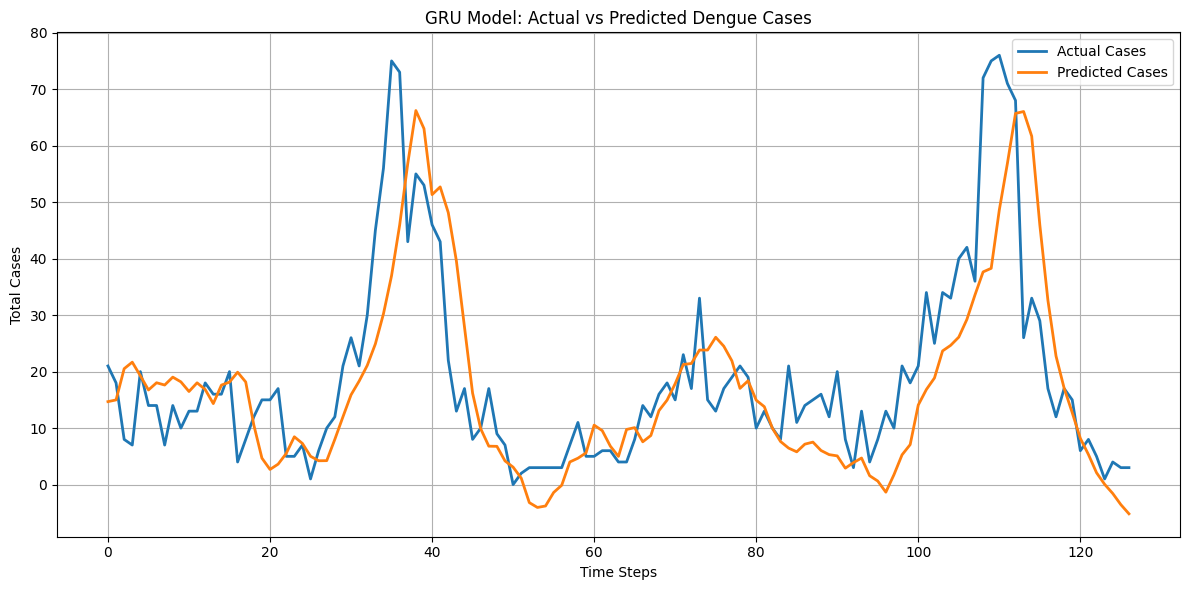

In [88]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Cases', linewidth=2)
plt.plot(y_pred_inv, label='Predicted Cases', linewidth=2)
plt.title("GRU Model: Actual vs Predicted Dengue Cases")
plt.xlabel("Time Steps")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Best trial: FrozenTrial(number=18, state=1, values=[0.02011046394426647], datetime_start=datetime.datetime(2025, 7, 29, 10, 53, 8, 742907), datetime_complete=datetime.datetime(2025, 7, 29, 10, 53, 29, 239496), params={'n_layers': 1, 'units_l0': 192, 'dropout_l0': 0.25124974868498806, 'optimizer': 'adam', 'batch_size': 32}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_layers': IntDistribution(high=3, log=False, low=1, step=1), 'units_l0': IntDistribution(high=256, log=False, low=64, step=32), 'dropout_l0': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'optimizer': CategoricalDistribution(choices=('adam', 'nadam', 'rmsprop')), 'batch_size': CategoricalDistribution(choices=(32, 64, 128))}, trial_id=18, value=None)
Best hyperparameters: {'n_layers': 1, 'units_l0': 192, 'dropout_l0': 0.25124974868498806, 'optimizer': 'adam', 'batch_size': 32}